# Классификатор тонов китайского языка с использованием CNN

Архитектура модели сверточной нейронной сети, используемой для создания классификатора тонов в многосложных китайских словах на диалекте путунхуа.
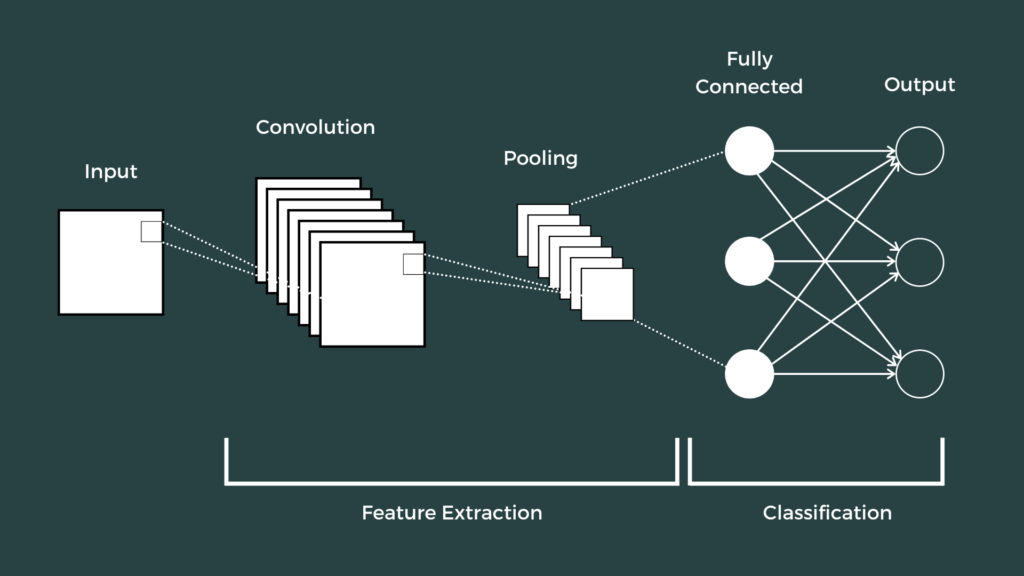

In [ ]:
#импортируем самые важные пакеты
import pandas as pd
import numpy as np
import matplotlib
import math
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import IPython.display as ipd
print('finished importing')
! pip install librosa
import librosa
import librosa.display
import requests
import os

!pip install pydub
from pydub import AudioSegment
from io import BytesIO
from scipy import signal

import requests
import numpy as np
from io import BytesIO
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment
from scipy import signal
from scipy.signal import find_peaks

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.utils import to_categorical

from sklearn.utils import class_weight

finished importing


# Импортируем датасет

In [ ]:
#импортируем датасет из HF
df = pd.read_csv("hf://datasets/MariyaMegre/hsk-dataset/hsk4_dataset.csv")
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,Unnamed: 0,Audio File,Word,Pinyin,Meaning,tones
0,0,https://raw.githubusercontent.com/ManiyaRaskol...,爱情,àiqíng,love (romantic),4-2
1,1,https://raw.githubusercontent.com/ManiyaRaskol...,标准,biāozhǔn,standard,1-3
2,2,https://raw.githubusercontent.com/ManiyaRaskol...,饼干,bǐnggān,biscuit,3-1
3,3,https://raw.githubusercontent.com/ManiyaRaskol...,材料,cáiliào,"data, material",2-4
4,4,https://raw.githubusercontent.com/ManiyaRaskol...,窗户,chuānghù,window,1-4


In [ ]:
# сделаем столбец  Unnamed: 0 индексами
df = df.rename(columns={'Unnamed: 0': 'id'}).set_index('id')
df.head()

,Audio File,Word,Pinyin,Meaning,tones
id,,,,,
0,https://raw.githubusercontent.com/ManiyaRaskol...,爱情,àiqíng,love (romantic),4-2
1,https://raw.githubusercontent.com/ManiyaRaskol...,标准,biāozhǔn,standard,1-3
2,https://raw.githubusercontent.com/ManiyaRaskol...,饼干,bǐnggān,biscuit,3-1
3,https://raw.githubusercontent.com/ManiyaRaskol...,材料,cáiliào,"data, material",2-4
4,https://raw.githubusercontent.com/ManiyaRaskol...,窗户,chuānghù,window,1-4


In [ ]:
# если 3 тон идет подряд 2 раза, первый слог читается в 2 тоне (3-3 –> 2-3)
df['tones'] = df['tones'].replace({'3-3': '2-3'})

# Построение спектрограмм

пгстроить для двух и более сложных слов

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29233 (\N{CJK UNIFIED IDEOGRAPH-7231}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24773 (\N{CJK UNIFIED IDEOGRAPH-60C5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


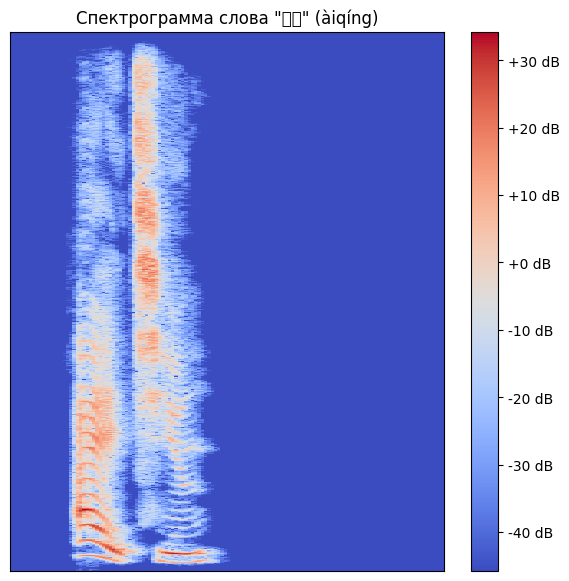

In [ ]:
# Функция для скачивания файла по URL
def download_file(url, local_filename):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename

# Получаем URL первого аудиофайла из таблицы
url = df['Audio File'].iloc[0]

# Скачиваем файл
local_filename = 'word_1.mp3'
download_file(url, local_filename)

# Загружаем аудиофайл с помощью librosa
audio, sr = librosa.load(local_filename)

# Удаляем временный файл (опционально)
os.remove(local_filename)

# Строим спектрограмму
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(7, 7))
librosa.display.specshow(Xdb)
plt.colorbar(format='%+2.0f dB')
plt.title('Спектрограмма слова "爱情" (àiqíng)')
plt.show()

<ipython-input-6-11328f96e958>:13: UserWarning: Glyph 29233 (\N{CJK UNIFIED IDEOGRAPH-7231}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-11328f96e958>:13: UserWarning: Glyph 24773 (\N{CJK UNIFIED IDEOGRAPH-60C5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29233 (\N{CJK UNIFIED IDEOGRAPH-7231}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24773 (\N{CJK UNIFIED IDEOGRAPH-60C5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


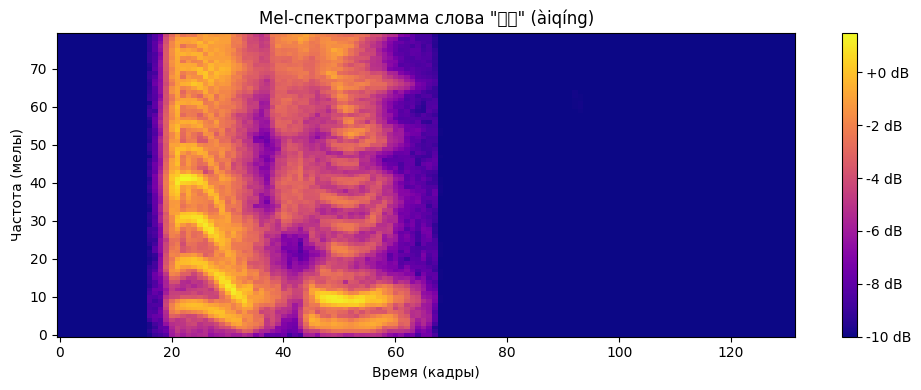

Размерность Mel-спектрограммы: (80, 132)


In [ ]:
# mel-spectrograms
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024,
                                         hop_length=512, n_mels=80,
                                         fmin=75, fmax=3700)

plt.figure(figsize=(10, 4))
plt.imshow(np.log10(mel_spec + 1e-10), aspect='auto',
           origin='lower', cmap=cm.plasma)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-спектрограмма слова "爱情" (àiqíng)')
plt.xlabel('Время (кадры)')
plt.ylabel('Частота (мелы)')
plt.tight_layout()
plt.show()

print(f"Размерность Mel-спектрограммы: {mel_spec.shape}")

# Подготовка данных

_____
Попробуем сделать также как в случае работы с RNN, где мы разделяля спектрограммы по Sxx, c mfcc

**Если для RNN мы подавали на вход Sxx, то для CNN больше подойдет mfcc:**

Sxx – это временная последовательность спектров мощности. RNN обрабатывает последовательности, а Sxx (спектрограмма) — это последовательность векторов частот, поэтому отлично подходит. MFCC (Mel-Frequency Cepstral Coefficients) — это компактное представление спектра, оптимизированное для работы с речью/звуком. Mfcc подходит для CNN, потому что CNN хорошо работают с локальными паттернами в компактных представлениях.

Сразу делить через mfcc не удалось, данных разделяются не корректно. Выполнить разделения к в случае RNN по Sxx также невозможно, так как извлечь mfcc возможно исключительно из аудиофайла.  

**Попробовала, но не получилось:**
1. Делить аудио по границам спектрограммы
2. Делить аудио по паузе – нет очевидно паузы
3. Делить аудио по времени – не получилось так как все слоги разной длины
4. Делить аудио по расстоянию между пиками

**Итоговый способ раздедения аудио – Разделение аудио по энергетическому балансу**

Как это сделать:
1. Находим границу при которой энергия звука до граинцы приблизительно равна энергии звука после границы,
2. Разделяем аудио по этой границы и обрезаем тишину
2. Из уже обрезанных аудио извлекаем mfcc

In [ ]:
nperseg = 1024
nfft = 1024 * 4
hop_length = 512
n_mfcc = 13
fixed_mfcc_time = 30


def load_audio(url):
    """Загружает mp3 по url, конвертирует во float64-моноволны через librosa"""
    response = requests.get(url)
    audio = AudioSegment.from_mp3(BytesIO(response.content))
    audio.export("temp.wav", format="wav")
    y, sr = librosa.load("temp.wav", sr=None)
    return y, sr


def get_spectrogram(samples, fs):
    """Создаёт спектрограмму (Sxx) из аудиосигнала"""
    f, t, Sxx = signal.spectrogram(samples, fs, nperseg=nperseg, nfft=nfft)
    Sxx = Sxx[:86]
    return Sxx


def split_spectrogram(Sxx):
    """Делит спектрограмму на 2 части по локальному минимуму"""
    q1 = Sxx.shape[1] // 4
    q3 = 3 * q1
    center = np.argmin(Sxx[:, q1:q3].max(axis=0))
    center += q1
    return trim_silences(Sxx[:, :center]), trim_silences(Sxx[:, center:]), center

def trim_silence_from_audio(samples, threshold=0.01):
    """Обрезает тишину в аудиосигнале по амплитуде"""
    energy = np.abs(samples)
    norm_energy = energy / np.max(energy) if np.max(energy) != 0 else energy
    mask = norm_energy > threshold
    if not np.any(mask):
        return samples
    start = np.argmax(mask)
    end = len(mask) - np.argmax(mask[::-1])
    return samples[start:end]

def get_mfcc_from_samples(samples, sr, max_len=fixed_mfcc_time):
    """Извлекает MFCC и падит/обрезает по времени"""
    mfcc = librosa.feature.mfcc(y=samples.astype(float), sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc



from scipy.signal import find_peaks

def find_split_by_energy_balance(samples, fs, frame_ms=10, hop_ms=5):
    """Находит такую точку, где энергия слева ≈ энергии справа"""
    frame_len = int(frame_ms / 1000 * fs)
    hop_len = int(hop_ms / 1000 * fs)

    energy = np.array([
        np.sum(np.abs(samples[i:i+frame_len])**2)
        for i in range(0, len(samples) - frame_len, hop_len)
    ])

    total_energy = np.sum(energy)
    cumulative_energy = np.cumsum(energy)
    split_idx = np.argmin(np.abs(cumulative_energy - total_energy / 2))
    split_sample = split_idx * hop_len

    return split_sample


def process_audio_from_url(url):
    samples, fs = load_audio(url)
    Sxx = get_spectrogram(samples, fs)
    Sxx1, Sxx2, _ = split_spectrogram(Sxx)

    # Надёжная версия деления
    split_sample = find_split_by_energy_balance(samples, fs)

    #делим по точке без сдвигов
    samples1 = trim_silence_from_audio(samples[:split_sample])
    samples2 = trim_silence_from_audio(samples[split_sample:])

    mfcc1 = get_mfcc_from_samples(samples1, fs)
    mfcc2 = get_mfcc_from_samples(samples2, fs)

    return mfcc1, mfcc2, Sxx, Sxx1, Sxx2, samples1, samples2, fs


In [ ]:
#проверим на первых пяти словах
for i in range(0,6):
  url = df['Audio File'].iloc[i]

  mfcc1, mfcc2, Sxx_full, Sxx1, Sxx2, samples1, samples2, fs = process_audio_from_url(url)
  print(f'Аудио для слова {i}')
  print("🔊 Слог 1:")
  display(Audio(samples1, rate=fs))

  print("🔊 Слог 2:")
  display(Audio(samples2, rate=fs))


Аудио для слова 0
🔊 Слог 1:


🔊 Слог 2:


Аудио для слова 1
🔊 Слог 1:


🔊 Слог 2:


Аудио для слова 2
🔊 Слог 1:


🔊 Слог 2:


Аудио для слова 3
🔊 Слог 1:


🔊 Слог 2:


Аудио для слова 4
🔊 Слог 1:


🔊 Слог 2:


Аудио для слова 5
🔊 Слог 1:


🔊 Слог 2:


In [ ]:
# создадим класс для обработки слов разной длины
class MFCCExtractor:
    def __init__(self, audio):
        self.audio = audio
        self.samples = None
        self.fs = None

    def load(self):
        """Превращает pydub.AudioSegment в float-формат для обработки"""
        temp_path = "temp.wav"
        self.audio.export(temp_path, format="wav")
        self.samples, self.fs = librosa.load(temp_path, sr=None)

    def trim_silence_from_audio(self, samples, threshold=0.01):
        energy = np.abs(samples)
        norm_energy = energy / np.max(energy) if np.max(energy) > 0 else energy
        mask = norm_energy > threshold
        if not np.any(mask):
            return samples
        start = np.argmax(mask)
        end = len(mask) - np.argmax(mask[::-1])
        return samples[start:end]

    def get_mfcc(self, samples, max_len=30, n_mfcc=13):
        mfcc = librosa.feature.mfcc(y=samples.astype(float), sr=self.fs, n_mfcc=n_mfcc)
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        return mfcc

    def split_by_energy_balance(self, n_parts, frame_ms=10, hop_ms=5):
        frame_len = int(frame_ms / 1000 * self.fs)
        hop_len = int(hop_ms / 1000 * self.fs)

        energy = np.array([
            np.sum(np.abs(self.samples[i:i+frame_len])**2)
            for i in range(0, len(self.samples) - frame_len, hop_len)
        ])
        cumulative = np.cumsum(energy)
        total = cumulative[-1]

        targets = [i * total / n_parts for i in range(1, n_parts)]
        split_idxs = []
        for target in targets:
            idx = np.argmin(np.abs(cumulative - target))
            split_idxs.append(idx * hop_len)

        split_samples = []
        prev = 0
        for idx in split_idxs + [len(self.samples)]:
            split_samples.append(self.samples[prev:idx])
            prev = idx

        return split_samples

    def process(self, num_syllables):
        self.load()
        segments = self.split_by_energy_balance(num_syllables)
        mfccs = []
        for seg in segments:
            trimmed = self.trim_silence_from_audio(seg)
            mfcc = self.get_mfcc(trimmed)
            mfccs.append(mfcc)
        return mfccs


In [ ]:
# функция для обработки всего датафрейма
def process_audio_df_mfcc(df):
    results = []

    for url, hanzi in zip(df['Audio File'], df['Word']):
        try:
            response = requests.get(url)
            audio = AudioSegment.from_mp3(BytesIO(response.content))
            processor = MFCCExtractor(audio)

            num_syllables = len(hanzi)  # или другой способ подсчёта
            mfcc_list = processor.process(num_syllables)

            results.append(mfcc_list)
        except Exception as e:
            print(f"Ошибка для {url}: {e}")
            results.append([None])

    df['mfcc'] = results
    return df


In [ ]:
process_audio_df_mfcc(df)
df.head()

,Audio File,Word,Pinyin,Meaning,tones,mfcc_syllables,mfcc
id,,,,,,,
0,https://raw.githubusercontent.com/ManiyaRaskol...,爱情,àiqíng,love (romantic),4-2,"[[[-415.5251818564494, -342.1774669164974, -26...","[[[-415.5251818564494, -342.1774669164974, -26..."
1,https://raw.githubusercontent.com/ManiyaRaskol...,标准,biāozhǔn,standard,1-3,"[[[-557.9863480884842, -489.4067299875443, -36...","[[[-557.9863480884842, -489.4067299875443, -36..."
2,https://raw.githubusercontent.com/ManiyaRaskol...,饼干,bǐnggān,biscuit,3-1,"[[[-543.9822530378947, -481.1007098884524, -37...","[[[-543.9822530378947, -481.1007098884524, -37..."
3,https://raw.githubusercontent.com/ManiyaRaskol...,材料,cáiliào,"data, material",2-4,"[[[-611.9049645580998, -508.4091720161966, -44...","[[[-611.9049645580998, -508.4091720161966, -44..."
4,https://raw.githubusercontent.com/ManiyaRaskol...,窗户,chuānghù,window,1-4,"[[[-464.60343669183914, -389.1524063846788, -3...","[[[-464.60343669183914, -389.1524063846788, -3..."


In [ ]:
# проверим данные на пропуски
df.isnull().sum()

,0
Audio File,0
Word,0
Pinyin,0
Meaning,0
tones,1
mfcc_syllables,0
mfcc,0


В данных есть одно слово с нулевым тонов (без тона), поэтому присутсвует один пропуск в столбце tones, удалим эту строку из данных.

In [ ]:
df = df.dropna()

Теперь необходимо закодировать метки классов с помощью One-Hot кодирования, преобразованные данные должны выглядеть следующим образом:

Тон 1 → [1, 0, 0, 0]

Тон 2 → [0, 1, 0, 0]

Тон 3 → [0, 0, 1, 0]

Тон 4 → [0, 0, 0, 1]

В случае многосложных слов будет создан список с закодированным значением каждого тона.




In [ ]:
# функция для кодирования таргета

def encode_tones(tones_str):
    tones = list(map(int, tones_str.split('-')))
    return [to_categorical(tone-1, num_classes=4) for tone in tones]

df['tones_onehot'] = df.tones.apply(encode_tones)

In [ ]:
df.head()

,Audio File,Word,Pinyin,Meaning,tones,mfcc_syllables,mfcc,tones_onehot
id,,,,,,,,
0,https://raw.githubusercontent.com/ManiyaRaskol...,爱情,àiqíng,love (romantic),4-2,"[[[-415.5251818564494, -342.1774669164974, -26...","[[[-415.5251818564494, -342.1774669164974, -26...","[[0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0]]"
1,https://raw.githubusercontent.com/ManiyaRaskol...,标准,biāozhǔn,standard,1-3,"[[[-557.9863480884842, -489.4067299875443, -36...","[[[-557.9863480884842, -489.4067299875443, -36...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]]"
2,https://raw.githubusercontent.com/ManiyaRaskol...,饼干,bǐnggān,biscuit,3-1,"[[[-543.9822530378947, -481.1007098884524, -37...","[[[-543.9822530378947, -481.1007098884524, -37...","[[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0]]"
3,https://raw.githubusercontent.com/ManiyaRaskol...,材料,cáiliào,"data, material",2-4,"[[[-611.9049645580998, -508.4091720161966, -44...","[[[-611.9049645580998, -508.4091720161966, -44...","[[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]]"
4,https://raw.githubusercontent.com/ManiyaRaskol...,窗户,chuānghù,window,1-4,"[[[-464.60343669183914, -389.1524063846788, -3...","[[[-464.60343669183914, -389.1524063846788, -3...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]]"


Создадим новый датафрейм с разбиением слов по слогам для последовательной обработки.

In [ ]:
# создаём новый датафрейм для слогов
syllable_df = pd.DataFrame(columns=['mfcc', 'tone', 'word_id', 'syllable_pos'])

for word_id, (tones, spec) in enumerate(zip(df.tones_onehot, df.mfcc)):
    for syllable_pos, (tone_part, mfcc_part) in enumerate(zip(tones, spec)):
        syllable_df.loc[len(syllable_df)] = {
            'mfcc': mfcc_part,
            'tone': tone_part,
            'word_id': word_id,
            'syllable_pos': syllable_pos
        }
syllable_df

,mfcc,tone,word_id,syllable_pos
0,"[[-415.5251818564494, -342.1774669164974, -261...","[0.0, 0.0, 0.0, 1.0]",0,0
1,"[[-210.56845617039704, -222.48197431417623, -2...","[0.0, 1.0, 0.0, 0.0]",0,1
2,"[[-557.9863480884842, -489.4067299875443, -364...","[1.0, 0.0, 0.0, 0.0]",1,0
3,"[[-243.37299468108378, -258.3575051717519, -32...","[0.0, 0.0, 1.0, 0.0]",1,1
4,"[[-543.9822530378947, -481.1007098884524, -371...","[0.0, 0.0, 1.0, 0.0]",2,0
...,...,...,...,...
1070,"[[-555.636543720578, -508.49304439111995, -469...","[0.0, 0.0, 0.0, 1.0]",602,0
1071,"[[-225.23346819359426, -238.56770265119826, -2...","[0.0, 0.0, 1.0, 0.0]",602,1
1072,"[[-366.1202472607046, -311.80401927627685, -30...","[0.0, 1.0, 0.0, 0.0]",603,0
1073,"[[-242.43892668070376, -281.8567607484765, -36...","[1.0, 0.0, 0.0, 0.0]",603,1


Проверим все ли mfcc одинаковой длины в итоговом датафрейме, так как в обратном случае CNN не сможет их обработать.

In [ ]:
set(mfcc.shape for mfcc in syllable_df['mfcc'])

{(13, 30)}

Все хорошо, новый датафоейм создан, теперь нужно выполнить разделение на тренировочную и тестовую выборку.

In [ ]:
X = syllable_df['mfcc'].to_list()
y = np.array(syllable_df['tone'].to_list())

X = np.stack(X, axis=0)
X = X[..., np.newaxis]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y.argmax(axis=1))
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1))

#Проверим размерности
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (645, 13, 30, 1) (645, 4)
Val: (215, 13, 30, 1) (215, 4)
Test: (215, 13, 30, 1) (215, 4)


# Спектрограммы

In [ ]:
# Функция для скачивания файла по URL
def download_file(url, local_filename):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename

url = df['Audio File'].iloc[0]

# Скачиваем файлы
local_ton_1 = download_file(url_ton_1, 'word_118.mp3')
local_ton_2 = download_file(url_ton_2, 'word_78.mp3')
local_ton_3 = download_file(url_ton_3, 'word_121.mp3')
local_ton_4 = download_file(url_ton_4, 'word_27.mp3')

# Загружаем аудиофайлы с помощью librosa
ton_1, sr1 = librosa.load(local_ton_1)
ton_2, sr2 = librosa.load(local_ton_2)
ton_3, sr3 = librosa.load(local_ton_3)
ton_4, sr4 = librosa.load(local_ton_4)

# Удаляем временные файлы (опционально)
os.remove(local_ton_1)
os.remove(local_ton_2)
os.remove(local_ton_3)
os.remove(local_ton_4)


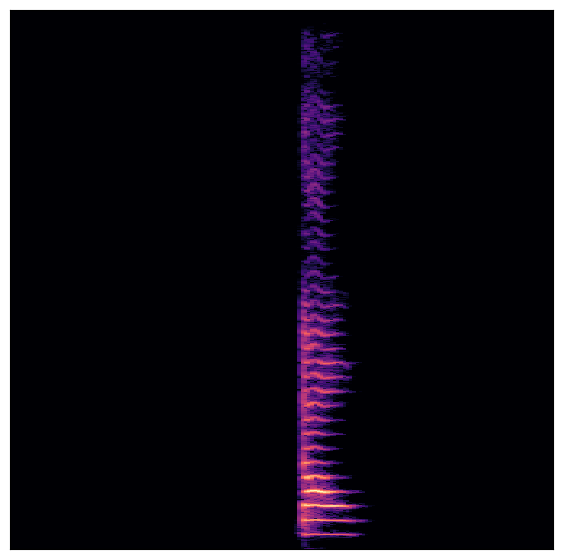

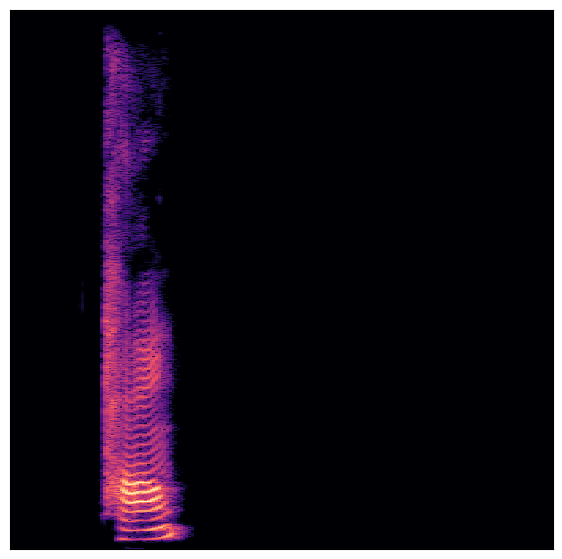

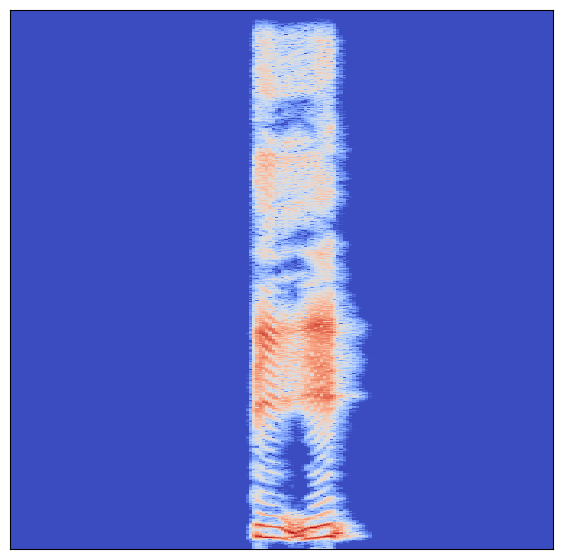

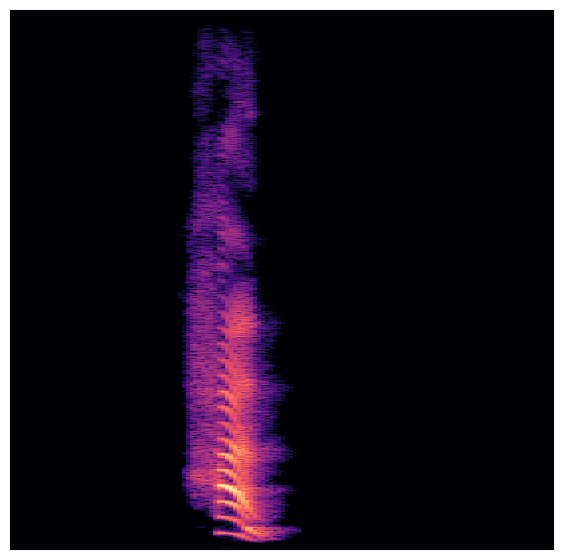

In [ ]:
# построим спектрограммы для каждого тона
X = librosa.stft(ton_1)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(7, 7))
librosa.display.specshow(Xdb)

X2 = librosa.stft(ton_2)
Xdb2 = librosa.amplitude_to_db(abs(X2))
plt.figure(figsize=(7,7))
librosa.display.specshow(Xdb2)

X3 = librosa.stft(ton_3)
Xdb3 = librosa.amplitude_to_db(abs(X3))
plt.figure(figsize=(7,7))
librosa.display.specshow(Xdb3)

X4 = librosa.stft(ton_4)
Xdb4 = librosa.amplitude_to_db(abs(X4))
plt.figure(figsize=(7,7))
librosa.display.specshow(Xdb4)


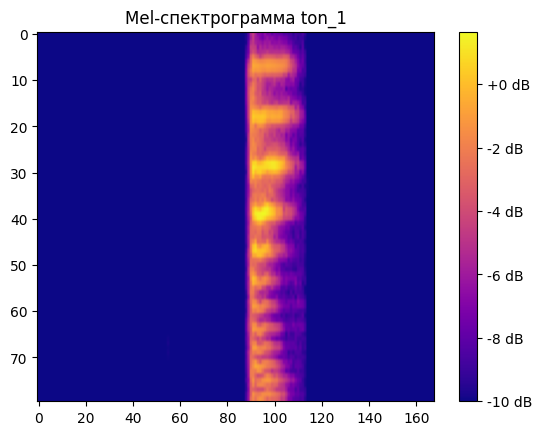

(80, 168)


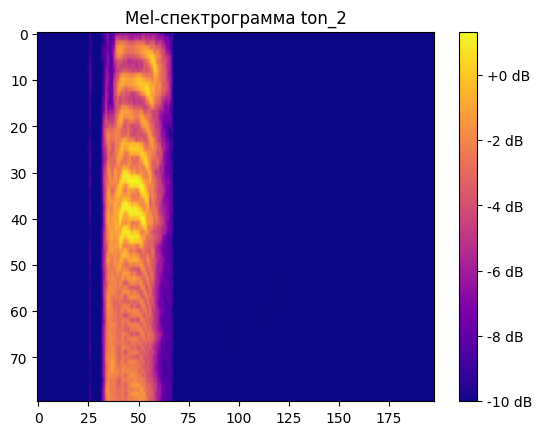

(80, 198)


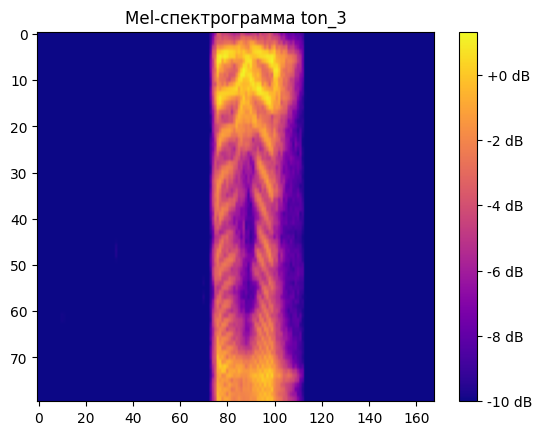

(80, 168)


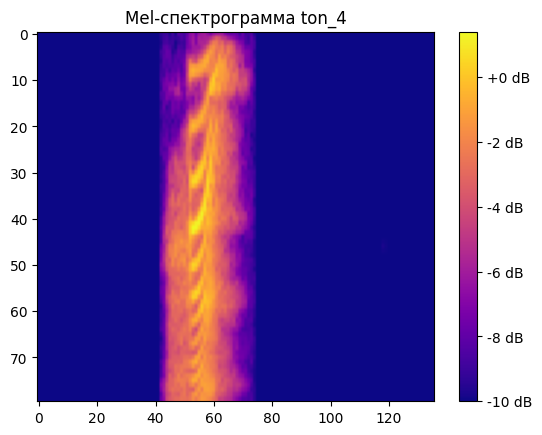

(80, 136)


In [ ]:
# mel-spectrograms
import matplotlib.cm as cm

# Mel-спектрограммы
mel1 = librosa.feature.melspectrogram(y=ton_1, sr=sr1, n_fft=1024, hop_length=512, n_mels=80, fmin=75, fmax=3700)
plt.imshow(np.log10(mel1 + 1e-10), aspect='auto', cmap=cm.plasma)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-спектрограмма ton_1')
plt.show()
print(mel1.shape)

mel2 = librosa.feature.melspectrogram(y=ton_2, sr=sr2, n_fft=1024, hop_length=512, n_mels=80, fmin=75, fmax=3700)
plt.imshow(np.log10(mel2 + 1e-10), aspect='auto', cmap=cm.plasma)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-спектрограмма ton_2')
plt.show()
print(mel2.shape)

mel3 = librosa.feature.melspectrogram(y=ton_3, sr=sr3, n_fft=1024, hop_length=512, n_mels=80, fmin=75, fmax=3700)
plt.imshow(np.log10(mel3 + 1e-10), aspect='auto', cmap=cm.plasma)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-спектрограмма ton_3')
plt.show()
print(mel3.shape)

mel4 = librosa.feature.melspectrogram(y=ton_4, sr=sr4, n_fft=1024, hop_length=512, n_mels=80, fmin=75, fmax=3700)
plt.imshow(np.log10(mel4 + 1e-10), aspect='auto', cmap=cm.plasma)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-спектрограмма ton_4')
plt.show()
print(mel4.shape)


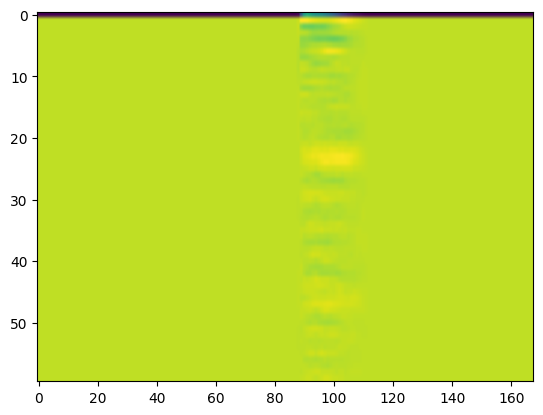

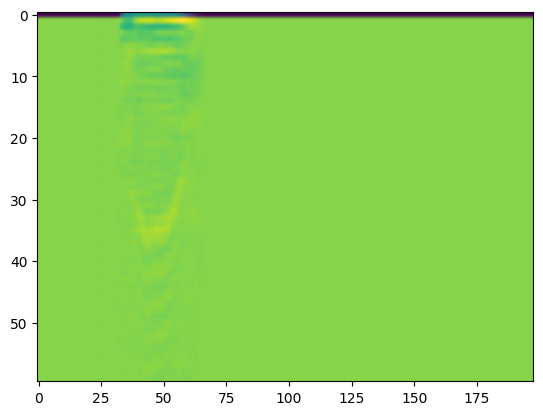

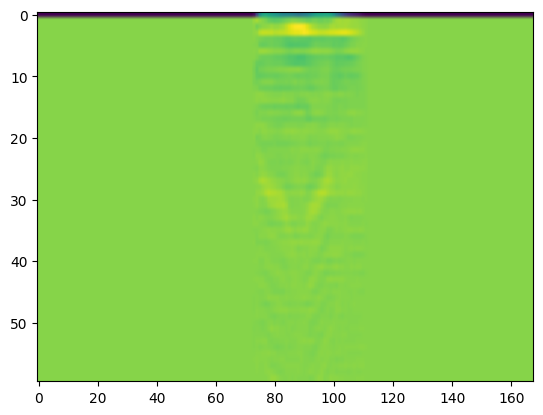

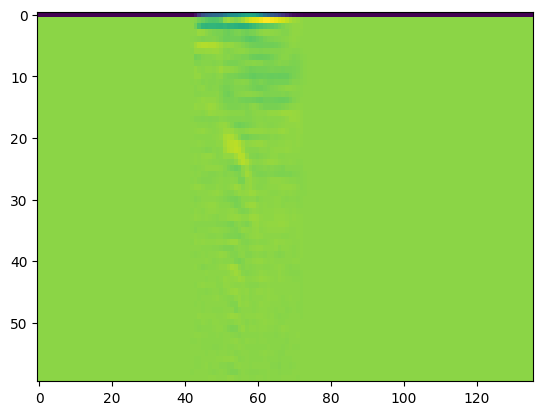

(60, 136)


In [ ]:
# MFCC – мел-частотный кепстр представляет собой представление краткосрочного спектра мощности звука

mfcc = librosa.feature.mfcc(y=ton_1, sr=sr1, n_mfcc=60)
plt.imshow(mfcc, aspect='auto', cmap=cm.viridis)
plt.show()

mfcc = librosa.feature.mfcc(y=ton_2, sr=sr2, n_mfcc=60)
plt.imshow(mfcc, aspect='auto', cmap=cm.viridis)
plt.show()

mfcc = librosa.feature.mfcc(y=ton_3, sr=sr3, n_mfcc=60)
plt.imshow(mfcc, aspect='auto', cmap=cm.viridis)
plt.show()

mfcc = librosa.feature.mfcc(y=ton_4, sr=sr4, n_mfcc=60)
plt.imshow(mfcc, aspect='auto', cmap=cm.viridis)
plt.show()
print(mfcc.shape)

def mp3tomfcc(file_path, max_pad):
  audio, sample_rate = librosa.core.load(file_path)
  mfcc = librosa.feature.mfcc(y=ton, sr=sr, n_mfcc=60)
  pad_width = max_pad - mfcc.shape[1]
  mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
  return mfcc


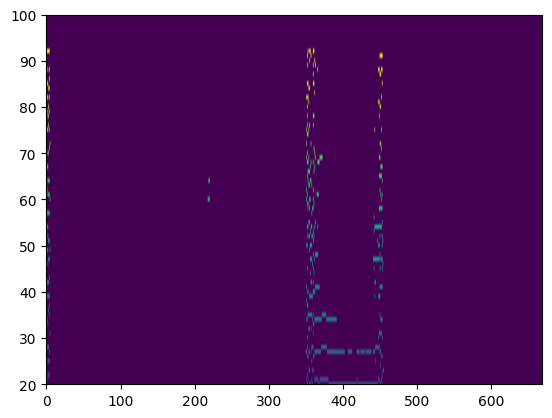

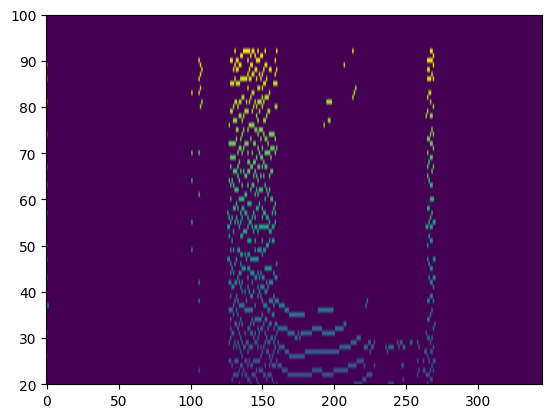

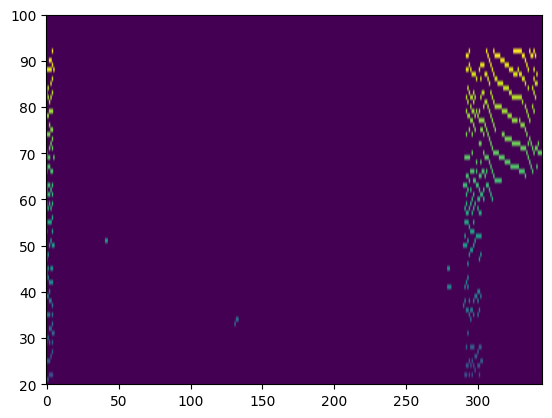

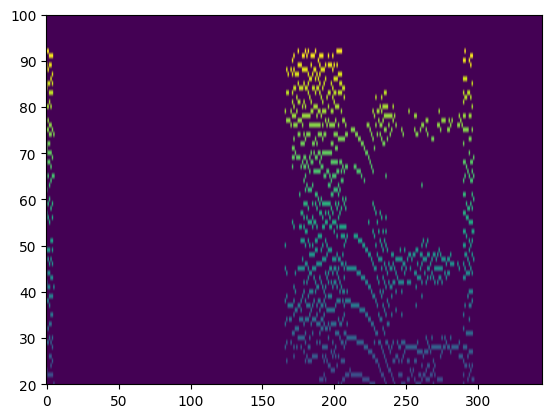

In [ ]:
# Pitch (я так поняла измеряет частоту тона)

pitch, mag = librosa.core.piptrack(y=ton_1, sr=sr1, n_fft=512)
plt.imshow(pitch, aspect='auto')
plt.ylim([20,100])
plt.show()

pitch, mag = librosa.core.piptrack(y=ton_2[0:sr2*2], sr=sr2, n_fft=512)
plt.imshow(pitch, aspect='auto')
plt.ylim([20,100])
plt.show()

pitch, mag = librosa.core.piptrack(y=ton_3[0:sr3*2], sr=sr3, n_fft=512)
plt.imshow(pitch, aspect='auto')
plt.ylim([20,100])
plt.show()

pitch, mag = librosa.core.piptrack(y=ton_4[0:sr4*2], sr=sr4, n_fft=512)
plt.imshow(pitch, aspect='auto')
plt.ylim([20,100])
plt.show()



# Настройка и обучение модели

In [ ]:
#создаем классификатор
def get_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

input_shape = X_train.shape[1:]  # (13, 30, 1)
num_classes = 4
model = get_cnn_model(input_shape, num_classes)



In [ ]:
#считаем веса классов
y_train_int = np.argmax(y_train, axis=1)

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights = dict(enumerate(class_weights_array))


In [ ]:
#обучаем модель
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.2333 - loss: 3.0902 - val_accuracy: 0.2279 - val_loss: 1.4435
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.3525 - loss: 1.4836 - val_accuracy: 0.2465 - val_loss: 1.3901
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.3531 - loss: 1.3447 - val_accuracy: 0.2372 - val_loss: 1.3855
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.3070 - loss: 1.2962 - val_accuracy: 0.2465 - val_loss: 1.3864
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.3452 - loss: 1.2626 - val_accuracy: 0.2698 - val_loss: 1.3524
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.3568 - loss: 1.2591 - val_accuracy: 0.3302 - val_loss: 1.3536
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.4113 - loss: 1.1662 - val_accuracy: 0.3209 - val_loss: 1.3587
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.4471 - loss: 1.2056 - val_accuracy: 0.316

# Оценка эффективности модели

In [ ]:
model.evaluate(X_test, y_test, batch_size=3, verbose=1)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4386 - loss: 1.3817


[1.3466960191726685, 0.4465116262435913]

In [ ]:
#проверка на переобчуение
model.evaluate(X_train, y_train, batch_size=3, verbose=1)

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6587 - loss: 0.8579


[0.8237175941467285, 0.6527131795883179]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


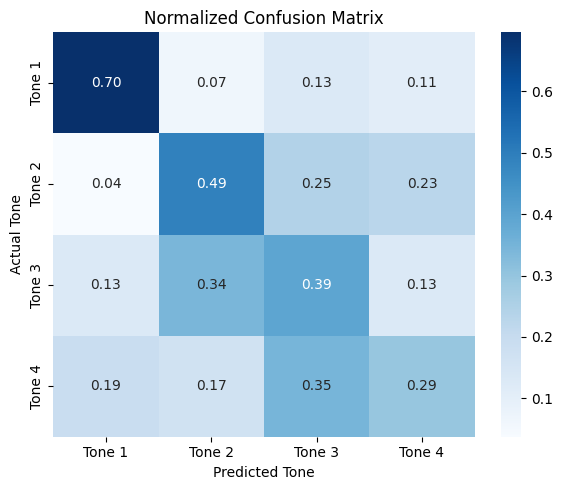

In [ ]:
# построим матрицу ошибок

y_pred_proba = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_proba, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', cbar=True,
            xticklabels=['Tone 1', 'Tone 2', 'Tone 3', 'Tone 4'],
            yticklabels=['Tone 1', 'Tone 2', 'Tone 3', 'Tone 4'])

plt.ylabel('Actual Tone')
plt.xlabel('Predicted Tone')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true_labels,
    y_pred_labels,
    target_names=['Tone 1', 'Tone 2', 'Tone 3', 'Tone 4'],
    digits=2
)
print(report)

              precision    recall  f1-score   support

      Tone 1       0.59      0.70      0.64        46
      Tone 2       0.47      0.49      0.48        53
      Tone 3       0.25      0.39      0.30        38
      Tone 4       0.51      0.29      0.37        78

    accuracy                           0.45       215
   macro avg       0.46      0.47      0.45       215
weighted avg       0.47      0.45      0.44       215



In [ ]:
# 2. Средние значения по всем классам
precision_macro = precision_score(y_true_labels, y_pred_labels, average='macro')
recall_macro    = recall_score(y_true_labels, y_pred_labels, average='macro')
f1_macro        = f1_score(y_true_labels, y_pred_labels, average='macro')

print("Усредненное значение метрик:")
print(f"Precision: {precision_macro:.2f}")
print(f"Recall:    {recall_macro:.2f}")
print(f"F1-score:  {f1_macro:.2f}")


Усредненное значение метрик:
Precision: 0.46
Recall:    0.47
F1-score:  0.45


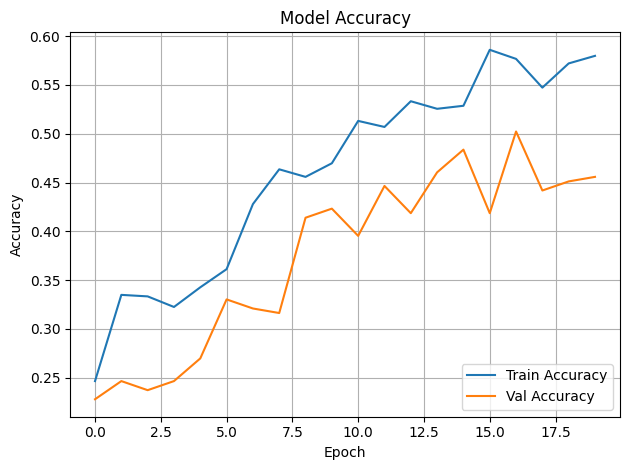

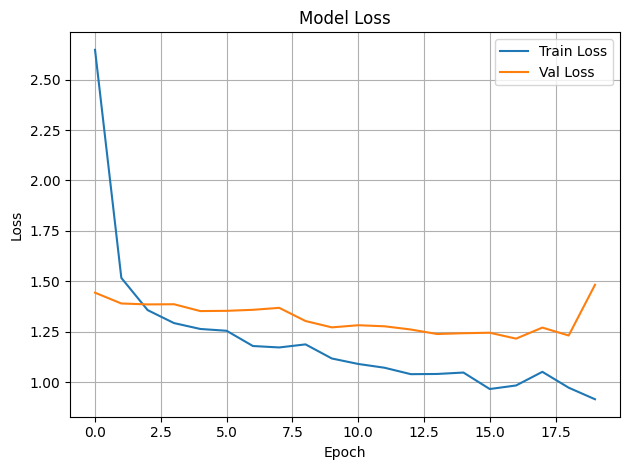

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

